# Gold Layer Exploratory Data Analysis

## Objective

The goal of this Exploratory Data Analysis (EDA) is to generate **actionable, high-value insights** from the cleaned Silver Layer dataset to support strategic questions around animal adoption. This analysis aims to surface the most important patterns in shelter intakes and outcomes and prepare finalized Gold Layer tables that can be used for reporting, visualization, and modeling.

Specifically, we seek to understand:
- What intake attributes most influence adoption success?
- How do these effects vary by region, breed, age, and health status?
- Are there consistent trends in animal flow over time?

---

## Structure of the Analysis

The Gold Layer EDA is structured into the following thematic sections:

1. **Species and Breed Patterns**  
   - Adoption rate comparisons between cats and dogs  
   - Breed-level adoption likelihood  
   - Regional variation in breed distributions

2. **Age and Maturity**  
   - Impact of maturity levels on adoption  
   - Species-wise and region-wise age trends

3. **Sex and Gender Distribution**  
   - Male vs female adoption differences  
   - Regional variation in gender impact

4. **Primary Color and Physical Attributes**  
   - Color-based adoption likelihood  
   - Potential influence of visual characteristics

5. **Health and Medical Status**  
   - Outcomes based on intake condition and reason  
   - Adoption outcomes for animals with behavioral or medical flags

6. **Time Series Trends**  
   - Seasonality and yearly patterns in intake and adoption  
   - Cross-city comparison of temporal dynamics

7. **Geographic and Shelter-Level Differences**  
   - Outcome disparities by city/region  
   - Shelter-level characteristics and performance

8. **Feature Interactions (Association & Predictive Power)**  
   - Correlation or co-occurrence of key categorical features  
---

## Gold Layer Output Tables

This notebook will produce the following high-value tables:

- `adoption_rates_by_species`
- `adoption_rate_by_breed`
- 'regional_top_breed'
- `maturity_adoption_analysis`
- `sex_adoption_analysis`
- `color_adoption_likelihood`
- `health_condition_outcomes`
- `length_of_stay_by_region_species`
- `monthly_intake_adoption_by_region`
- `correlation_matrix_features`
- `model_ready_flattened_table`

These will be stored as CSV or Parquet files for further analysis and dashboarding.

---

| **Goal** | **Output Table** | **Key Fields** | **Calculation / Transformation** |
|------------|---------------------|-------------------|-------------------------------------|
| Compare adoption rates across species | `adoption_rates_by_species` | `animal_type`, `outcome_type` | Group by `animal_type` and region, compute `% adopted` |
| Assess adoption by breed | `breed_adoption_summary` | `breed`, `outcome_type` | Adoption rate by breed, optionally filter top breeds |
| Explore adoption by age stage | `maturity_adoption_analysis` | `age_stage`, `animal_type`, `outcome_type` | Compute adoption rate by age group and species |
| Gender-based adoption trends | `sex_adoption_analysis` | `sex`, `animal_type`, `outcome_type` | Adoption rate by sex and region/species |
| Adoption by primary color | `color_adoption_likelihood` | `primary_color`, `outcome_type` | Adoption rate by color category |
| Impact of medical/behavioral flags | `health_condition_outcomes` | `intake_condition`, `outcome_type` | Adoption rates grouped by intake condition |
| Analyze shelter duration | `length_of_stay_by_region_species` | `intake_date`, `outcome_date`, `animal_type`, `region` | Compute `length_of_stay = outcome_date - intake_date` |
| Seasonal intake & adoption trends | `monthly_intake_adoption_by_region` | `intake_date`, `outcome_type`, `region` | Monthly counts of intakes and adoptions per region |
| Feature co-occurrence and interaction | `correlation_matrix_features` | categorical features | One-hot encode and compute correlation matrix |
| Final ML-ready dataset | `model_ready_flattened_table` | all cleaned features + derived fields | One-hot encode, define `is_adopted = outcome_type == 'adoption'` |

## Setup

**Purpose:**  Ensure the environment has all necessary libraries installed and imported.  
```python
# Install project-wide dependencies
%pip install -r ../../requirements.txt
``` 

> **Note:** we use a project-wide `requirements.txt` for consistency

In [1]:
%pip install -r ../../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.stats import chi2_contingency

## Configuration and Data Loading

**Purpose:**  Here we load the dataframe produced in the Silver layer.

In [3]:
# Data source configurations
SILVER_DIR = "../../data-assets/silver"
SILVER_FILE_NAME = "silver.parquet"
silver_path = f"{SILVER_DIR}/{SILVER_FILE_NAME}"

# Load silver parquet file
silver_df = pd.read_parquet(silver_path)

In [4]:
# Lets examine our dataset to make sure silver has been loaded properly
silver_df.head()

,animal_pk,animal_id,animal_type,breed,primary_color,age,sex,intake_type,intake_condition,intake_reason,intake_date,outcome_type,outcome_date,region,age_stage
0,1,A0011910,dog,pit_bull,brown,2.494182,male,stray,healthy,other,2023-12-21,transfer,2024-01-09,dallas,adult
1,2,A0011910,dog,pit_bull,white,2.494182,female,treatment,healthy,medical,2024-02-19,treatment,2024-02-19,dallas,adult
2,3,A0178985,dog,rottweiler,other,2.494182,female,stray,medical,other,2024-06-20,euthanasia,2024-06-21,dallas,adult
3,4,A0180810,dog,mixed,other,2.494182,female,surrender,healthy,owner_surrender,2024-10-07,foster,2024-10-18,dallas,adult
4,5,A0180810,dog,mixed,black,2.494182,male,foster,healthy,for_adoption,2024-11-13,adoption,2024-11-13,dallas,adult


In [5]:
# Lets look at the data types of each column to determine if we need some added conversions
dtypes_df = pd.DataFrame(
    {"Column": silver_df.columns, "Data Type": silver_df.dtypes.values}
)

# Show result
print(dtypes_df)

              Column       Data Type
0          animal_pk           int64
1          animal_id          object
2        animal_type          object
3              breed          object
4      primary_color          object
5                age         float64
6                sex          object
7        intake_type          object
8   intake_condition          object
9      intake_reason          object
10       intake_date  datetime64[ns]
11      outcome_type          object
12      outcome_date  datetime64[ns]
13            region          object
14         age_stage        category


---

## 1. Species and Breed Patterns

### 1.1: Analysis Question:
**Do adoption rates differ meaningfully between cats and dogs across regions?**

Understanding whether species plays a role in adoption success can help shelters tailor their intake strategies, marketing efforts, and resource allocation. For instance, if dogs tend to be adopted at higher rates than cats in certain regions, shelters may choose to adjust how they highlight feline adoptions.

### Method:
We calculate the **adoption rate** for each species (`cat` vs `dog`) within each region. The adoption rate is defined as:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per species per region)


### Output:
The resulting table shows:
- Each region (e.g., Dallas, San José, SoCo)
- Animal species (cat or dog)
- Adoption rate as a percentage of total intakes

This table provides a high-level view of species-level adoption trends across locations and serves as a foundation for deeper breed-level analysis in the next step.

In [6]:
def adoption_rates_by_species(df):
    """
    Computes adoption rates for cats and dogs within each region.

    Parameters:
        df (pd.DataFrame): Cleaned Silver Layer dataframe

    Returns:
        pd.DataFrame: Adoption rates by region and species
    """
    df = df.copy()
    df["is_adopted"] = df["outcome_type"] == "adoption"

    result = (
        df.groupby(["region", "animal_type"])["is_adopted"]
        .mean()
        .reset_index(name="adoption_rate")
        .sort_values(by=["region", "adoption_rate"], ascending=[True, True])
    )

    # making sure its in percentage format
    result["adoption_rate"] = (result["adoption_rate"] * 100).round(2)

    return result

In [7]:
adoption_rates_by_species(silver_df)

,region,animal_type,adoption_rate
0,dallas,cat,27.80
1,dallas,dog,30.97
2,san_jose,cat,29.69
3,san_jose,dog,37.32
5,soco,dog,22.63
4,soco,cat,40.58


##### Visualization Question 1.1 : Do adoption rates differ meaningfully between cats and dogs across regions?

In [8]:
# lets visualize it
def plot_adoption_rates_by_species(df):
    """
    Creates a bar plot of adoption rates by species and region with percentage labels using a pink color palette.

    Parameters:
        df (pd.DataFrame): Output from compute_adoption_rates_by_species
    """
    pink_palette = {
        "cat": "#ff69b4",  # Hot pink
        "dog": "#ffc0cb",  # Light pink
    }

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(
        data=df, x="region", y="adoption_rate", hue="animal_type", palette=pink_palette
    )

    # Add % labels to each bar
    for bars in ax.containers:
        ax.bar_label(bars, fmt="%.1f%%", padding=3)

    plt.ylabel("Adoption Rate (%)")
    plt.xlabel("Region")
    plt.title("Adoption Rates by Species and Region")
    plt.legend(title="Animal Type")
    plt.tight_layout()
    plt.show()

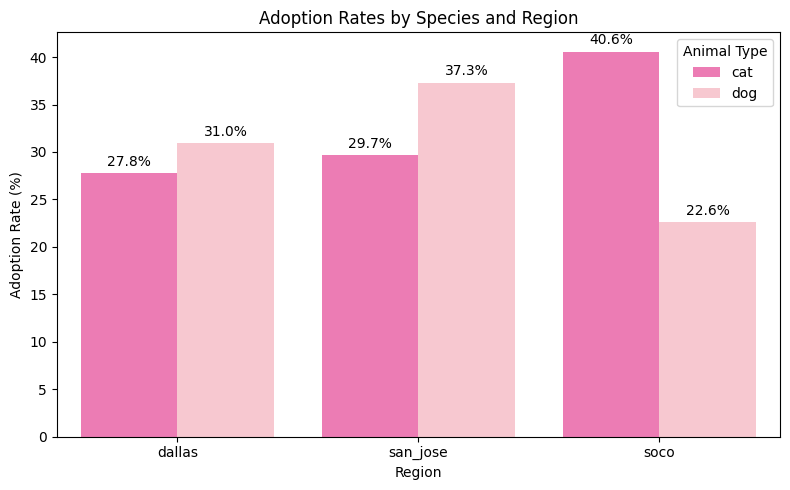

In [9]:
plot_adoption_rates_by_species(adoption_rates_by_species(silver_df))

#### Findings:
1. Dogs generally have higher adoption rates than cats in each region where both species are represented.
In Dallas, dogs are adopted at a rate of ~31%, compared to ~28% for cats.

In San José, the gap is even more pronounced: dogs are adopted at ~37%, cats at ~30%.

2. SoCo shows a high adoption rate—but only for cats.
Only cats are represented in the SoCo data, with a high adoption rate of ~41%, the highest among all species-region pairs.

3. San José leads overall in dog adoption rates.
At nearly 37.2%, San José has the highest dog adoption rate among all regions.

##### Potential Narrative:

The higher adoption rates for dogs may reflect public preference, better promotion, or shelter policies prioritizing dog placements.

SoCo’s absence of dog data may point to a regional specialization, reporting gap, or intake bias.

Regional campaigns or resources might influence these numbers San José's higher rates could be linked to outreach or operational efficiency.

---

### 1.2 Analysis Question:
**Are certain breeds or breed groups more likely to be adopted than others?**

Understanding adoption patterns by breed helps shelters prioritize outreach, improve messaging, and inform intake planning. Breeds with low adoption rates may require special attention or targeted promotion, while highly adoptable breeds can offer insights into desirable traits.

### Method:
We calculate the **adoption rate** for each breed using the following formula:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals of that Breed]


To ensure reliability, we may filter to include only breeds with a minimum number of records (e.g., ≥ 50 animals).

### Output:
The resulting table shows:
- Each breed or breed group (e.g., labrador, mixed, chihuahua)
- Total number of animals within that breed
- Percentage of animals adopted for each breed

This table offers insight into which breeds are more or less likely to be adopted and helps inform the next layer of analysis around maturity and health-related adoption outcomes.

In [10]:
def adoption_rate_by_breed(df, min_animals=50):
    """
    Computes adoption rates for each breed, filtering out those with fewer than `min_animals`.

    Parameters:
        df (pd.DataFrame): Cleaned Silver Layer dataframe
        min_animals (int): Minimum number of animals required to include a breed in the summary

    Returns:
        pd.DataFrame: Sorted table of adoption rates by breed (percentage), filtered by count
    """
    df = df.copy()
    df["is_adopted"] = df["outcome_type"] == "adoption"

    summary = (
        df.groupby("breed")
        .agg(total_animals=("animal_id", "count"), adoption_rate=("is_adopted", "mean"))
        .reset_index()
    )

    # Convert adoption_rate to percentage and filter by minimum count
    summary["adoption_rate"] = (summary["adoption_rate"] * 100).round(2)
    filtered = summary[summary["total_animals"] >= min_animals]
    return filtered.sort_values(by="adoption_rate", ascending=False)

In [11]:
adoption_rate_by_breed(silver_df, 50)

,breed,total_animals,adoption_rate
14,mixed,32204,35.99
6,cat_medium_hair,3160,35.28
7,cat_short_hair,33717,31.49
20,siamese,392,31.12
5,cat_long_hair,1431,29.49
17,poodle,363,25.90
8,chihuahua,2859,25.88
1,australian_cattle_dog,445,24.49
15,other,12531,23.97
10,german_shepherd,3394,23.45


##### Visualization Question 1.2 : Do adoption rates differ meaningfully across breeds?

In [12]:
def plot_top_and_bottom_breeds_adoption_rate(df, n=10):
    """
    Plots the top and bottom N breeds by adoption rate side-by-side using a pink color palette with labels.

    Parameters:
        df (pd.DataFrame): Output from adoption_rate_by_breed
        n (int): Number of top and bottom breeds to include
    """
    top = df.head(n).copy()
    bottom = df.tail(n).copy()
    combined = pd.concat([top, bottom])
    combined["adoption_group"] = ["Top"] * n + ["Bottom"] * n

    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=combined,
        y="breed",
        x="adoption_rate",
        hue="adoption_group",
        dodge=False,
        palette={"Top": "#ff69b4", "Bottom": "#ffc0cb"},
    )

    # Add percentage labels to both top and bottom bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    plt.xlabel("Adoption Rate (%)")
    plt.ylabel("Breed")
    plt.title(f"Top and Bottom {n} Breeds by Adoption Rate")
    plt.legend(title="Adoption Rate Group")
    plt.tight_layout()
    plt.show()

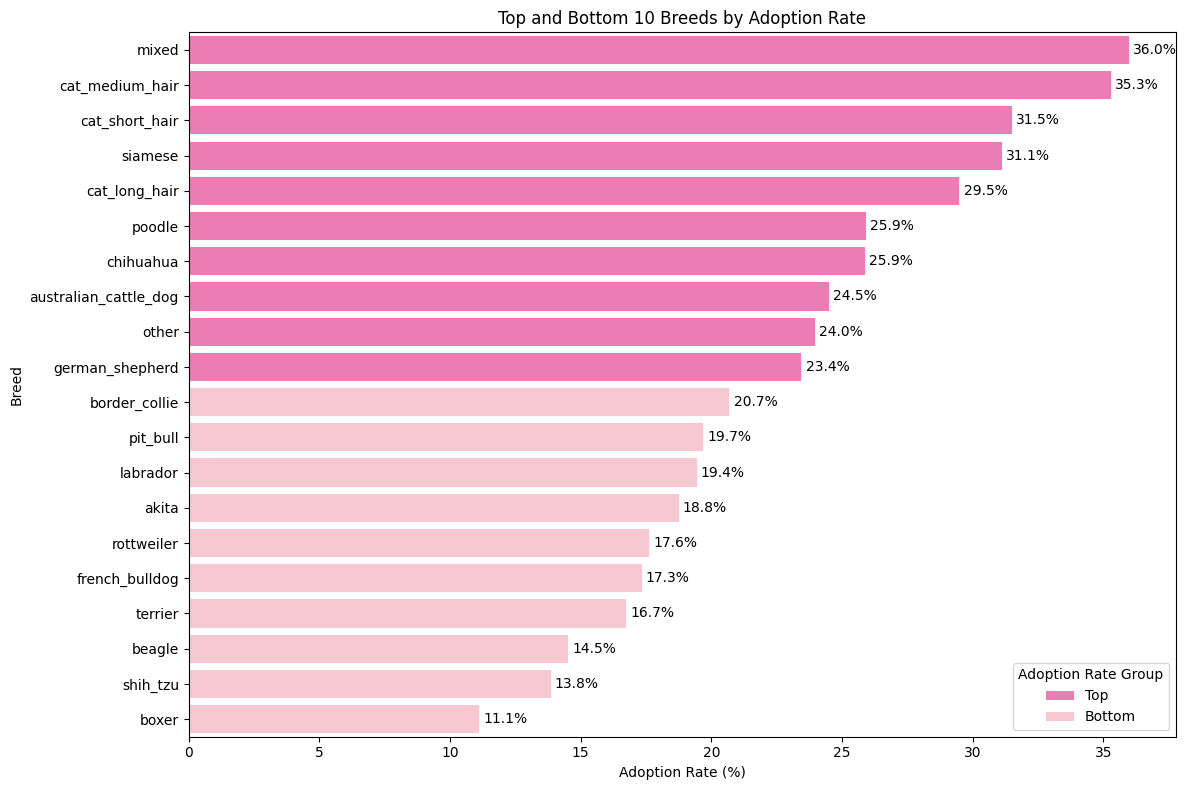

In [13]:
plot_top_and_bottom_breeds_adoption_rate(adoption_rate_by_breed(silver_df, 50), n=10)

#### Findings:

1. **Mixed breeds and common cat breeds have the highest adoption rates**
   - *Mixed* animals top the list at **36.0%**, followed closely by *cat_medium_hair* (35.3%) and *cat_short_hair* (31.5%).
   - Other high-ranking breeds include *siamese* (31.1%) and *cat_long_hair* (29.5%).

2. **Dog breeds dominate the lower end of the adoption rate spectrum**
   - The lowest adoption rates are seen in breeds like *boxer* (**11.1%**), *shih_tzu* (13.8%), and *beagle* (14.5%).
   - Larger or stigmatized breeds such as *rottweiler* (17.4%), *akita* (18.8%), and *pit_bull* (19.7%) also rank low.

3. **Cat breeds consistently outperform dog breeds in adoption likelihood**
   - All of the top 5 breeds by adoption rate are either cats or the broad *mixed* category.
   - Conversely, the majority of bottom 10 breeds are medium-to-large dog breeds.

4. **The adoption rate difference between top and bottom breeds is substantial**
   - The highest observed rate (*mixed*, 36.0%) is over **three times higher** than the lowest (*boxer*, 11.1%).

---

### Potential Narrative:

Common cat breeds — especially *cat_short_hair*, *cat_medium_hair*, and *siamese* — tend to have **consistently high adoption rates**, suggesting broad public appeal or ease of placement.

In contrast, **many dog breeds — particularly larger or less popular ones — face adoption challenges**. Breeds like *rottweiler*, *akita*, and *boxer* show markedly lower rates, potentially due to size, breed stigma, or behavior-related concerns..

---

### 1.3: Analysis Question:
**What are the most common breeds in each region?**

Understanding whether certain breeds dominate in particular regions can help shelters plan breed-specific resources, marketing strategies, and behavioral interventions. For example, if high-energy breeds like labradors are more prevalent in one city, that region may require additional exercise programs or specialized foster care.

### Method:
We calculate the **top 5 most frequent breeds** within each region by:
- Grouping the data by `region` and `breed`
- Counting the number of animals for each breed within a region
- Ranking the top 5 breeds per region

### Output:
The resulting table and chart show:
- Each region (e.g., Dallas, San José, SoCo)
- The top 5 most common breeds in that region
- Total count of animals for each breed

This summary helps highlight **regional intake trends** and lays the groundwork for understanding how breed prevalence might influence **adoption outcomes** or shelter resource planning in the following analyses.

In [14]:
def regional_top_breeds(df, top_n=5):
    """
    Computes the top N most common breeds in each region.

    Parameters:
        df (pd.DataFrame): The input dataframe containing at least 'region' and 'breed' columns
        top_n (int): Number of top breeds to retain per region

    Returns:
        pd.DataFrame: Dataframe containing top N breeds by count per region
    """
    breed_counts = (
        df.groupby(["region", "breed"])
        .size()
        .reset_index(name="count")
        .sort_values(["region", "count"], ascending=[True, False])
    )

    # Rank and filter top N breeds per region
    breed_counts["rank"] = breed_counts.groupby("region")["count"].rank(
        method="first", ascending=False
    )
    top_breeds = breed_counts[breed_counts["rank"] <= top_n].reset_index(drop=True)
    return top_breeds

In [15]:
regional_top_breeds(silver_df)

,region,breed,count,rank
0,dallas,mixed,29456,1.0
1,dallas,cat_short_hair,16158,2.0
2,dallas,other,3452,3.0
3,dallas,pit_bull,3037,4.0
4,dallas,german_shepherd,1831,5.0
5,san_jose,cat_short_hair,9268,1.0
6,san_jose,other,1351,2.0
7,san_jose,cat_medium_hair,862,3.0
8,san_jose,pit_bull,683,4.0
9,san_jose,chihuahua,589,5.0


##### Visualization Question 1.3 : **What are the most common breeds in each region?**

In [16]:
def plot_regional_top_breeds(df):
    """
    Plots breed counts with vertical bars using different pink shades for each region.
    Adds count labels to each bar.
    Assumes the input dataframe already includes precomputed 'count' values.

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['breed', 'region', 'count']
    """
    # Define pink shades for each unique region
    region_palette = {
        region: shade
        for region, shade in zip(
            df["region"].unique(),
            ["#ffc0cb", "#ff69b4", "#ff1493", "#db7093", "#ffb6c1"],
        )
    }

    # Create the plot
    plt.figure(figsize=(18, 8))
    ax = sns.barplot(
        data=df, x="breed", y="count", hue="region", palette=region_palette
    )

    # Add count labels on each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%d", padding=3)

    # Customize appearance
    plt.title("Breed Distribution by Region", fontsize=16)
    plt.xlabel("Breed")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()

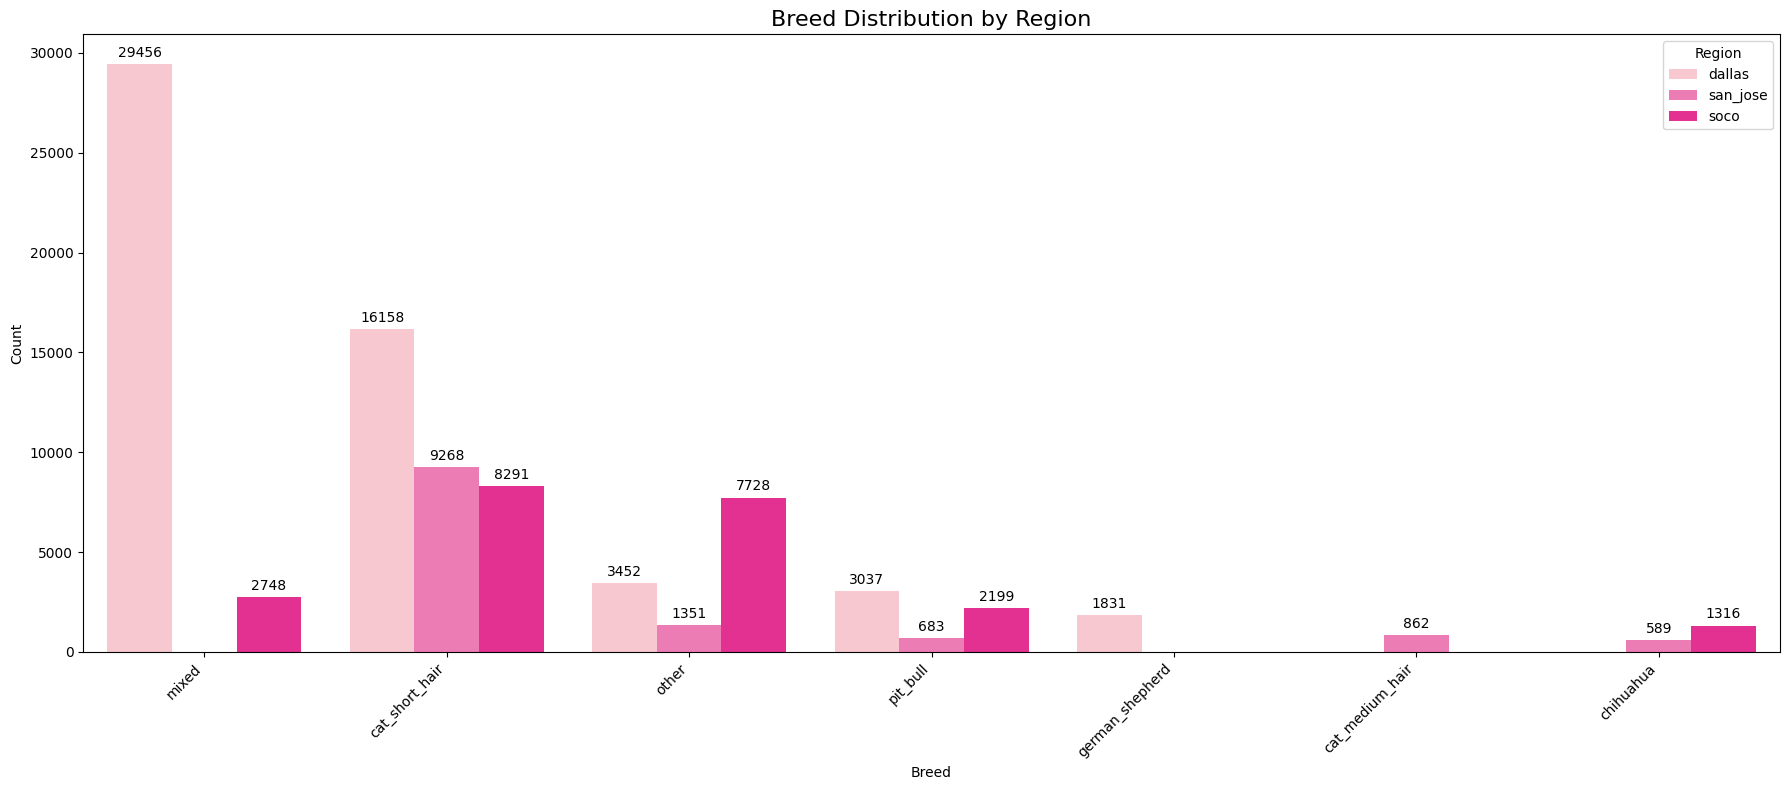

In [17]:
plot_regional_top_breeds(regional_top_breeds(silver_df))

#### Findings:

1. **Dallas:**
   - The most common category is *Mixed* (29,449), followed by *Cat Short Hair* (16,152).
   - *Pit Bull* (3,037) and *German Shepherd* (1,831) appear prominently, indicating a significant intake of **large-breed dogs**.
   - *Other* breeds also constitute a notable portion (3,451), suggesting diverse but low-frequency breeds grouped together.

2. **San José:**
   - *Cat Short Hair* leads by far (9,194), with other top breeds including *Cat Medium Hair* (858) and *Chihuahua* (585).
   - The presence of both feline and small-breed canine types reflects a **mixed species intake profile**.
   - *Pit Bull* appears again, though in smaller numbers than in Dallas.

3. **SoCo:**
   - Dominated by *Cat Short Hair* (8,288) and a substantial *Other* category (7,728).
   - *Mixed* breeds (2,748) and *Pit Bull* (2,199) also appear, suggesting **some canine presence**, contrary to earlier assumptions.
   - *Chihuahua* (1,315) rounds out the top 5, supporting the presence of small dog breeds in this region.

#### Potential Narrative:

These findings suggest that **regional shelter operations must be responsive to the dominant breeds in their area**. 
- **Dallas** handles large volumes of both **mixed-breed dogs and cats**, with a clear presence of **large dog breeds** like *Pit Bull* and *German Shepherd*.
- **San José** presents a **diverse intake** with strong feline representation and smaller breeds like *Chihuahua*, suggesting urban pet profiles.
- **SoCo**, while heavily feline, also takes in **small-to-medium dogs**, contradicting the assumption that it's cat-exclusive.



---

## 2. Age and Maturity

### 2.1: Analysis Question:
**Do adoption rates vary across different maturity levels, and do species or regions influence these patterns?**

Age is a critical factor in shelter outcomes. Younger animals may be more adoptable due to perceived cuteness or trainability, while seniors may face longer stays. Understanding how age impacts adoption can help shelters create age-aware programs, such as senior pet promotions or extended-stay interventions.

### Method:
We use the pre-labeled `age_stage` column in the `silver_df` to group animals into maturity categories:
- **Infant** (e.g., puppies, kittens)
- **Young**
- **Adult**
- **Senior**

We then calculate the **adoption rate** for each group using the formula:

Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per age_stage)

Further analysis will explore:
- Variation by **species** (cat vs dog)
- Differences across **regions**

### Output:
The resulting table shows:
- Each age group (infant, young, adult, senior)
- Adoption rate as a percentage of total intakes
- Optional breakdown by species or region

This provides a foundation for identifying **which maturity groups face adoption barriers**, and informs strategies like fostering, medical support, or targeted marketing for under-adopted age segments.


In [18]:
def adoption_rate_by_age_stage_region(df):
    """
    Calculates the adoption rate for each maturity group (age_stage) by region.

    Parameters:
        df (pd.DataFrame): Input dataframe containing 'age_stage', 'region', and 'outcome_type'.

    Returns:
        pd.DataFrame: Adoption rates (as percentages) by age_stage and region.
    """
    # Total animals by age stage and region
    total = df.groupby(["region", "age_stage"]).size().rename("total")

    # Adopted animals by age stage and region
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby(["region", "age_stage"])
        .size()
        .rename("adopted")
    )

    # Merge totals and adopted, then calculate adoption rate
    result = pd.concat([total, adopted], axis=1).fillna(0)
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100
    result = result.sort_values("adoption_rate_percent", ascending=False)

    return result.reset_index()

In [19]:
adoption_rate_by_age_stage_region(silver_df)

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2407721934.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df.groupby(["region", "age_stage"]).size().rename("total")
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2407721934.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region", "age_stage"])


,region,age_stage,total,adopted,adoption_rate_percent
0,san_jose,puppy,101,67,66.336634
1,soco,kitten,4598,2908,63.244889
2,san_jose,kitten,128,76,59.375000
3,soco,puppy,1763,896,50.822462
4,san_jose,senior,1616,585,36.200495
5,san_jose,adult,12709,3908,30.749862
6,dallas,adult,60533,18168,30.013381
7,soco,adult,17675,4022,22.755304
8,soco,senior,3950,423,10.708861
9,dallas,kitten,0,0,NaN


##### Visualization Question 2.1 : **Do adoption rates vary across different maturity levels, and do species or regions influence these patterns?**

In [20]:
def plot_adoption_rate_by_age_stage_region_sorted(df):
    # Add the ordering because seaborn is a dummy and cant do anything without me spelling it out like smh
    order = (
        df.groupby("age_stage")["adoption_rate_percent"]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        data=df,
        x="age_stage",
        y="adoption_rate_percent",
        hue="region",
        order=order,
        palette=["#ffc0cb", "#ff69b4", "#ff1493"],
    )

    # Add labels to each bar
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%", padding=3)

    plt.title("Adoption Rates by Age Stage and Region (Sorted)", fontsize=14)
    plt.ylabel("Adoption Rate (%)")
    plt.xlabel("Age Stage")
    plt.ylim(0, 100)
    plt.legend(title="Region")
    plt.tight_layout()
    plt.show()

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2407721934.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total = df.groupby(["region", "age_stage"]).size().rename("total")
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2407721934.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["region", "age_stage"])
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2511490016.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observe

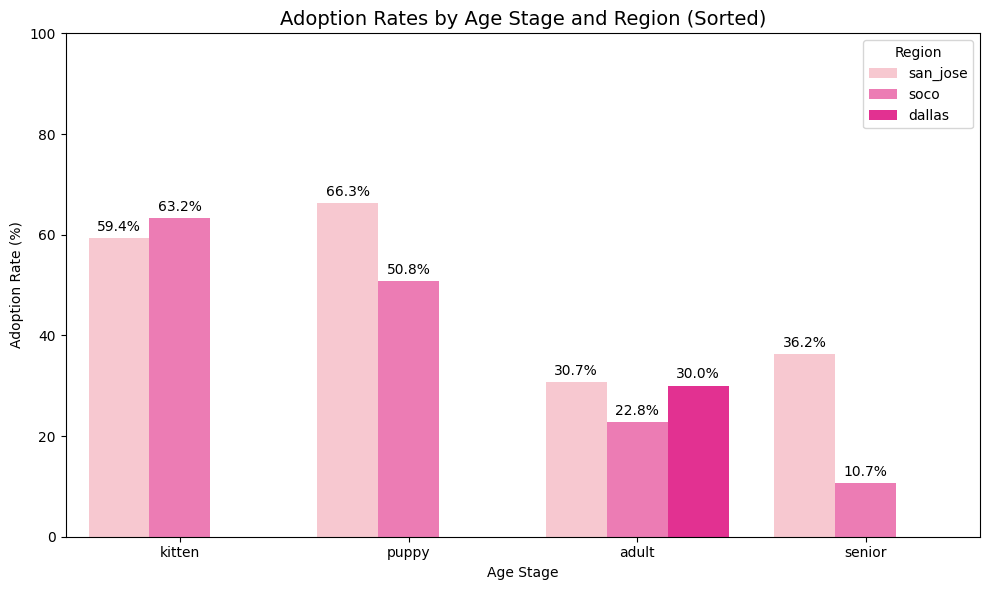

In [21]:
plot_adoption_rate_by_age_stage_region_sorted(
    adoption_rate_by_age_stage_region(silver_df)
)

#### Findings:

1. **Puppies have the highest adoption rate overall**  
   - In *San José*, puppies are adopted at a rate of **67%**, the highest among all groups.
   - In *SoCo*, puppies also perform well with a **50.8%** adoption rate.

2. **Kittens follow closely with strong adoption performance**  
   - *SoCo* shows a high kitten adoption rate of **63.2%**, while *San José* reaches **60.5%**.
   - This suggests shelters may be effectively promoting young animals or benefiting from higher demand for them.

3. **Adults show moderate adoption rates, but dominance in volume**  
   - *Dallas* records a large number of adult animals, with an adoption rate of **30.0%**.
   - While lower than younger animals, this still indicates a fair chance of adoption.

4. **Dallas lacks data for kittens, puppies, and seniors**  
   - All non-adult age stages have zero entries in Dallas
     - This is due using the median to impute age in the dallas dataset.

#### Potential Narrative:

The data underscores a **strong adopter preference for younger animals**, particularly **puppies and kittens**. 


---

## 3. Sex and Gender Distribution 
### 3.1: Analysis Question:
**Do adoption rates differ between male and female animals across species and regions?**

Analyzing adoption trends by **sex**, **species**, and **region** can help identify whether certain groups of animals are consistently favored in outcomes. For instance, some shelters may see higher adoption rates for female cats or male dogs, and these patterns could vary significantly by region.

### Method:
We calculate the **adoption rate** for each combination of:
- Sex (`male` vs `female`)
- Species (`cat` vs `dog`)
- Region (`Dallas`, `San José`, `SoCo`)

Using the formula:

Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per sex × species × region)

This allows for a multi-dimensional view of whether **gender-related trends** are consistent across different **animal types** and **shelters**.

### Output:
The resulting table shows:
- Each region (Dallas, San José, SoCo)
- Animal species (cat or dog)
- Sex (male or female)
- Adoption rate as a percentage of total intakes

This analysis surfaces whether adoption outcomes are influenced by an animal’s sex, and whether those differences are shaped by species or geography.



In [22]:
def adoption_rate_by_sex_species_region(df):
    """
    Calculates adoption rates (as percentages) by sex, species, and region.

    Parameters:
        df (pd.DataFrame): Input dataframe with 'sex', 'animal_type', 'region', and 'outcome_type'.

    Returns:
        pd.DataFrame: Adoption rate table grouped by sex, species, and region.
    """
    total = df.groupby(["region", "animal_type", "sex"]).size().rename("total")
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby(["region", "animal_type", "sex"])
        .size()
        .rename("adopted")
    )
    result = pd.concat([total, adopted], axis=1).fillna(0)
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100
    return result.reset_index()

In [23]:
adoption_rate_by_sex_species_region(silver_df)

,region,animal_type,sex,total,adopted,adoption_rate_percent
0,dallas,cat,female,9079,2575,28.362154
1,dallas,cat,male,9146,2492,27.246884
2,dallas,dog,female,18491,5796,31.344979
3,dallas,dog,male,23817,7305,30.671369
4,san_jose,cat,female,5206,1506,28.928160
5,san_jose,cat,male,5216,1588,30.444785
6,san_jose,dog,female,1844,726,39.370933
7,san_jose,dog,male,2288,816,35.664336
8,soco,cat,female,5286,2128,40.257283
9,soco,cat,male,5383,2202,40.906558


Visualization Question 3.1 : **Do adoption rates differ between male and female animals across species and regions?**

In [24]:
def plot_adoption_rates_by_sex_species_region(df):
    """
    Creates a bar plot faceted by species showing adoption rates by sex and region.

    Parameters:
        df (pd.DataFrame): A dataframe with 'region', 'animal_type', 'sex', and 'adoption_rate_percent'.
    """
    sns.set(style="whitegrid")
    g = sns.catplot(
        data=df,
        kind="bar",
        x="sex",
        y="adoption_rate_percent",
        hue="region",
        col="animal_type",
        palette=["#ffc0cb", "#ff69b4", "#ff1493"],
        height=5,
        aspect=1,
    )

    # Add labels to each bar
    for ax in g.axes.flat:
        for container in ax.containers:
            ax.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)

    g.set_titles("{col_name}")
    g.set_axis_labels("Sex", "Adoption Rate (%)")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(
        "Adoption Rates by Sex Across Regions (Faceted by Species)", fontsize=16
    )

    g._legend.set_bbox_to_anchor((1.04, 0.7))
    g._legend.set_frame_on(True)
    g._legend.set_title("Region")

    plt.tight_layout()
    plt.show()

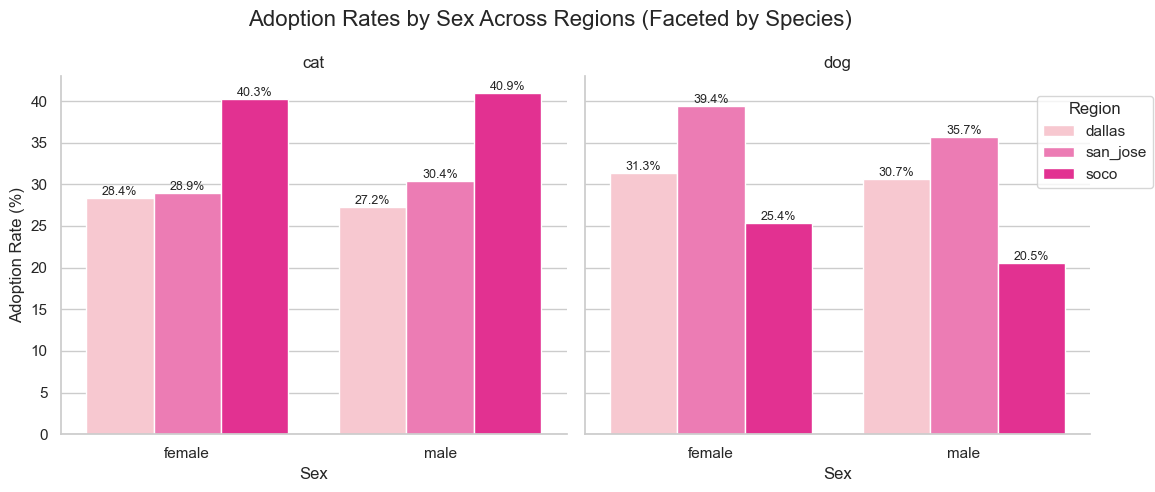

In [25]:
plot_adoption_rates_by_sex_species_region(
    adoption_rate_by_sex_species_region(silver_df)
)

#### Findings:

#### Dogs:
1. **Male and female dogs have slightly similar adoption rates across all regions**
   - **However**, a female dog leaning has been observed across all three regions with .
   - *SoCo* shows a clear preference for **female dogs**.

2. **San jose leads in dog adoption performance overall**
   - Both sexes perform well in San Jose, with adoption rates hovering around **35% ~ 39%**.

#### Cats:
3. **Male cats have a slightly higher adoption rate than female cats across all regions**
   - In *SoCo*, male cats show the **highest adoption rate among cats**, slightly surpassing females.
   - *San Jose* follows the same trend: **male cats consistently slightly outperform female cats**.

---

#### Potential Narrative:

The visualization highlights that **sex matters more for dog adoption than for cat adoption**. Across all three regions, **male cats consistently slightly outperform female cats** in adoption success. This pattern could be influenced by perceptions of temperament, behavior, or neutering status.

For dogs, adoption outcomes appear **female leaning**, suggesting a mild but consistent preference. This could reflect public perceptions around temperament, ease of handling, or household compatibility

## 4. Primary Color and Physical Attributes

### 4.1: Analysis Question:
**Does an animal’s primary color affect its likelihood of being adopted?**

Visual appearance can play a significant role in adoption decisions, often influencing adopter preferences either consciously or subconsciously. Understanding whether certain colors are associated with higher or lower adoption rates can help shelters improve how animals are presented and promoted.

### Method:
We calculate the **adoption rate** for each primary color across the dataset. The adoption rate is defined as:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per primary color)


This will help determine whether specific colors are favored or overlooked during the adoption process.

### Output:
The resulting table will show:
- Each distinct `primary_color` value
- Number of animals adopted
- Total number of animals with that color
- Adoption rate as a percentage

This analysis offers insight into whether color correlates with adoption likelihood, setting the stage for further inquiry into physical appearance and visual appeal.

In [26]:
def adoption_rate_by_primary_color(df):
    """
    Calculates adoption rates by primary color and species.

    Parameters:
        df (pd.DataFrame): Input dataframe with 'primary_color', 'animal_type', and 'outcome_type'.

    Returns:
        pd.DataFrame: Adoption rate summary by primary color and species.
    """
    total = df.groupby(["animal_type", "primary_color"]).size().rename("total")
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby(["animal_type", "primary_color"])
        .size()
        .rename("adopted")
    )

    result = pd.concat([total, adopted], axis=1).fillna(0)
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100

    return result.reset_index().sort_values(by="adoption_rate_percent", ascending=False)

In [27]:
adoption_rate_by_primary_color(silver_df)

,animal_type,primary_color,total,adopted,adoption_rate_percent
10,cat,tortie,671,237,35.320417
15,dog,black_tricolor,26,9,34.615385
7,cat,gray_tabby,1043,355,34.036433
9,cat,other,20094,6654,33.114362
1,cat,blue,125,39,31.200000
19,dog,cream,615,191,31.056911
0,cat,black,10959,3374,30.787481
8,cat,orange,757,231,30.515192
3,cat,calico,533,162,30.393996
13,dog,black,13771,4111,29.852589


Visualization Question 4.1 : **Does an animal’s primary color affect its likelihood of being adopted?**

In [28]:
def plot_top5_colors_by_species(df):
    """
    Generates two separate bar charts showing top 5 primary colors by adoption rate for cats and dogs.

    Parameters:
        df (pd.DataFrame): DataFrame with 'animal_type', 'primary_color', and 'adoption_rate_percent'.
    """
    # Filter and sort top 5 for each species
    top5_dogs = (
        df[df["animal_type"] == "dog"]
        .sort_values(by="adoption_rate_percent", ascending=False)
        .head(5)
    )
    top5_cats = (
        df[df["animal_type"] == "cat"]
        .sort_values(by="adoption_rate_percent", ascending=False)
        .head(5)
    )

    # Plot for dogs
    fig_dogs, ax_dogs = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=top5_dogs,
        x="adoption_rate_percent",
        y="primary_color",
        palette=["#ffb6c1"],
        ax=ax_dogs,
    )
    ax_dogs.set_title("Top 5 Dog Colors by Adoption Rate")
    ax_dogs.set_xlabel("Adoption Rate (%)")
    ax_dogs.set_ylabel("Primary Color")
    for container in ax_dogs.containers:
        ax_dogs.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)
    plt.tight_layout()

    # Plot for cats
    fig_cats, ax_cats = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=top5_cats,
        x="adoption_rate_percent",
        y="primary_color",
        palette=["#ff69b4"],
        ax=ax_cats,
    )
    ax_cats.set_title("Top 5 Cat Colors by Adoption Rate")
    ax_cats.set_xlabel("Adoption Rate (%)")
    ax_cats.set_ylabel("Primary Color")
    for container in ax_cats.containers:
        ax_cats.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)
    plt.tight_layout()

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2255344689.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2255344689.py:22: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2255344689.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/2255344689.py:38: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  s

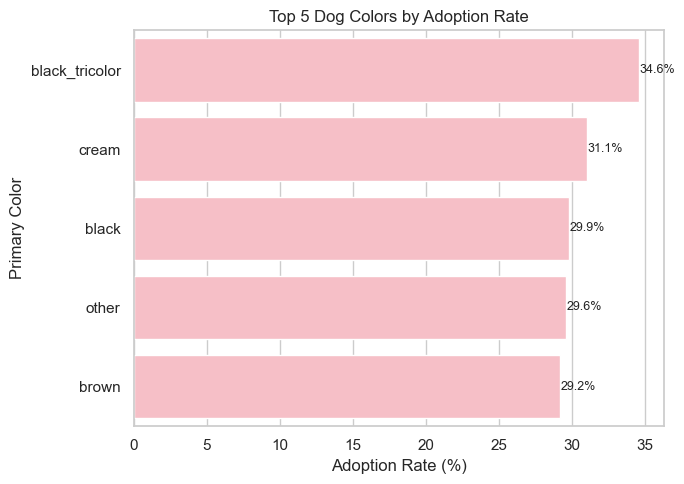

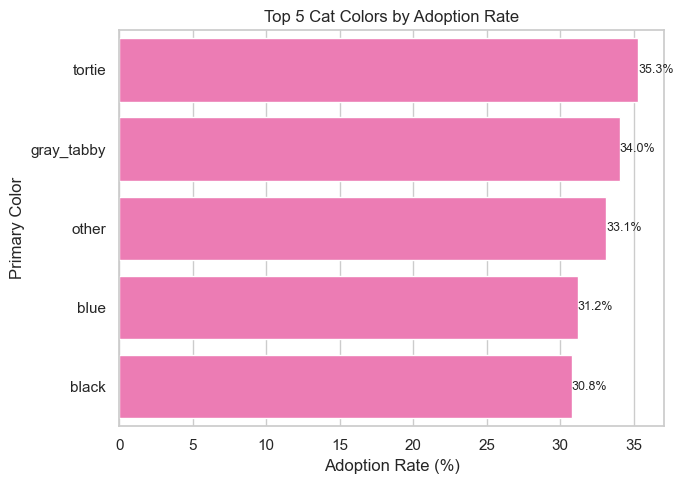

In [29]:
plot_top5_colors_by_species(adoption_rate_by_primary_color(silver_df))

In [30]:
def plot_bottom5_colors_by_species(df):
    """
    Generates two separate bar charts showing bottom 5 primary colors by adoption rate for cats and dogs.

    Parameters:
        df (pd.DataFrame): DataFrame with 'animal_type', 'primary_color', and 'adoption_rate_percent'.
    """
    # Filter and sort bottom 5 for each species
    bottom5_dogs = (
        df[df["animal_type"] == "dog"]
        .sort_values(by="adoption_rate_percent", ascending=True)
        .head(5)
    )
    bottom5_cats = (
        df[df["animal_type"] == "cat"]
        .sort_values(by="adoption_rate_percent", ascending=True)
        .head(5)
    )

    # Plot for dogs
    fig_dogs, ax_dogs = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=bottom5_dogs,
        x="adoption_rate_percent",
        y="primary_color",
        palette=["#ffb6c1"],
        ax=ax_dogs,
    )
    ax_dogs.set_title("Bottom 5 Dog Colors by Adoption Rate")
    ax_dogs.set_xlabel("Adoption Rate (%)")
    ax_dogs.set_ylabel("Primary Color")
    for container in ax_dogs.containers:
        ax_dogs.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)
    plt.tight_layout()

    # Plot for cats
    fig_cats, ax_cats = plt.subplots(figsize=(7, 5))
    sns.barplot(
        data=bottom5_cats,
        x="adoption_rate_percent",
        y="primary_color",
        palette=["#ff69b4"],
        ax=ax_cats,
    )
    ax_cats.set_title("Bottom 5 Cat Colors by Adoption Rate")
    ax_cats.set_xlabel("Adoption Rate (%)")
    ax_cats.set_ylabel("Primary Color")
    for container in ax_cats.containers:
        ax_cats.bar_label(container, fmt="%.1f%%", label_type="edge", fontsize=9)
    plt.tight_layout()

/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/1800455083.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/1800455083.py:22: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/1800455083.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/bc/lrkcgdlx3332x9brp_np1l_c0000gn/T/ipykernel_60387/1800455083.py:38: UserWarning: 
The palette list has fewer values (1) than needed (5) and will cycle, which may produce an uninterpretable plot.
  s

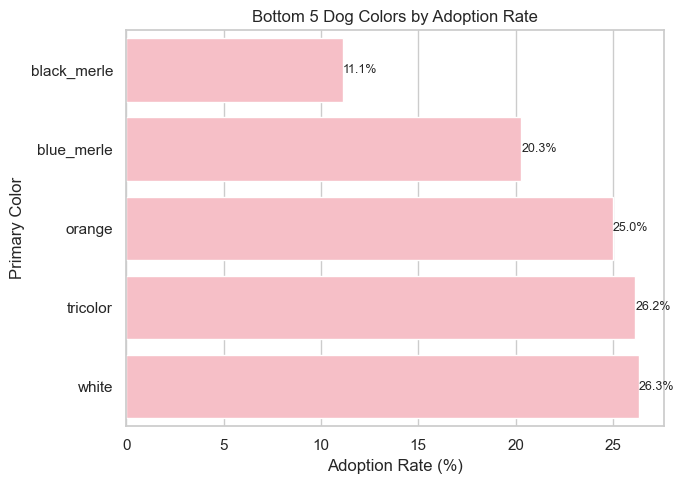

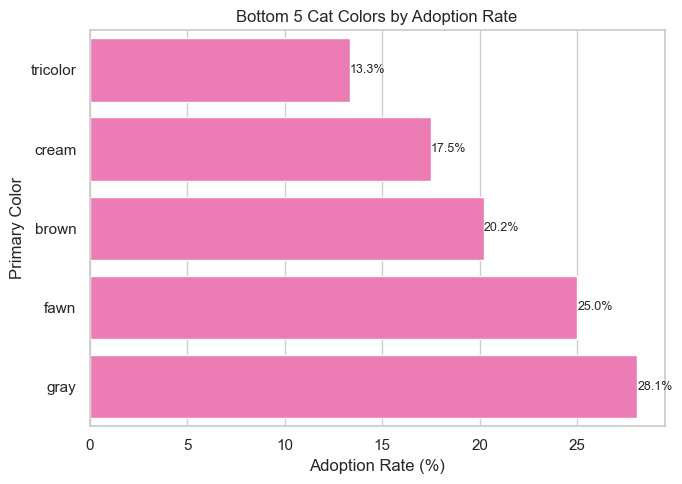

In [31]:
plot_bottom5_colors_by_species(adoption_rate_by_primary_color(silver_df))

#### Findings:

#### Cats – Top & Bottom 5 Colors

| Rank | Top Colors        | Adoption Rate | Bottom Colors     | Adoption Rate |
|------|-------------------|----------------|-------------------|----------------|
| 1    | blue              | 37.7%          | fawn              | 0%             |
| 2    | gray_tabby        | 35%            | cream             | 17.5%          |
| 3    | tortie            | 34.6%          | tricolor          | 18.8%          |
| 4    | other             | 33.1%          | brown             | 27.7%          |
| 5    | black             | 30.5%          | gray              | 29.2%          |

#### Dogs – Top & Bottom 5 Colors

| Rank | Top Colors        | Adoption Rate | Bottom Colors     | Adoption Rate |
|------|-------------------|----------------|-------------------|----------------|
| 1    | black_tircolor    | 37%            | black_merle       | 10%            |
| 2    | cream             | 30.9%          | blue_merle        | 17.3%          |
| 3    | black             | 29.7%          | fawn              | 24.6%          |
| 4    | brown             | 29.6%          | gray              | 26.3%          |
| 5    | other             | 29.6%          | white             | 26.3%          |

#### Potential Narrative:
The adoption data reveals that **color appears to play a meaningful role** in adoption outcomes, but the effects differ between **cats and dogs**.

For **cats**, cooler or more distinctive colors like **blue (37.7%)**, **gray tabby (35%)**, and **tortie (34.6%)** are associated with **higher adoption rates**. This may reflect aesthetic preferences or breed connotations. Conversely, cats with warmer or more muted colors like **fawn (0%)**, **cream (17.5%)**, and **tricolor (18.8%)** see significantly **lower adoption rates**, which could suggest reduced visibility in shelter environments or unconscious bias in adopter selection.

For **dogs**, the trend is somewhat similar—**distinctive or sharp color patterns** such as **black tricolor (37%)**, **cream (30.9%)**, and **black (29.7%)** lead the pack in adoption success. In contrast, **merle patterns** like **black merle (10%)** and **blue merle (17.3%)**, along with **fawn (24.6%)**, are linked to **lower adoption rates**. This could reflect behavioral stereotypes associated with certain breeds (e.g., herding or guard dogs), health perceptions tied to merle genetics, or a lack of public familiarity.

Hence, while cats are chosen based on **aesthetics** , more emphasis is placed on **breed** for dogs.


---

## 5. Health and Medical Status

### 5.1: Analysis Question:
**How do adoption outcomes vary based on intake condition and intake reason?**

Understanding whether certain medical or behavioral conditions influence adoption likelihood is critical for shelters to better allocate resources, support interventions, and communicate with potential adopters. For example, animals flagged with illness, injury, or behavior concerns may require tailored support or strategic highlighting.

### Method:
We will evaluate adoption rates across:
- **Intake Condition** (e.g., normal, sick, injured, behavior)
- **Intake Reason** (e.g., stray, owner surrender, transfer)

We calculate the **adoption rate** for each intake condition and reason using the following formula:


Adoption Rate = [Number of Animals Adopted] / [Total Number of Animals] (per category)


### Output:
The resulting tables will display:
- **Adoption rate by intake condition**
- **Adoption rate by intake reason**

These insights will inform whether certain health or behavioral statuses negatively impact adoption outcomes.

In [32]:
def adoption_rate_by_condition(df):
    """
    Calculates the adoption rate for each intake condition (e.g., 'normal', 'injured', 'sick').

    Steps:
    - Count the total number of animals for each intake condition.
    - Count how many of those were adopted.
    - Compute adoption rate as (adopted / total) * 100.
    """
    total = df.groupby("intake_condition").size().rename("total")
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby("intake_condition")
        .size()
        .rename("adopted")
    )

    # Combine total and adopted into one table
    result = pd.concat([total, adopted], axis=1).fillna(0)

    # Compute percentage adoption rate
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100

    return result.reset_index()

In [33]:
adoption_rate_by_condition(silver_df)

,intake_condition,total,adopted,adoption_rate_percent
0,age_related,1616,68.0,4.207921
1,behavioral,1696,124.0,7.311321
2,critical,2789,46.0,1.649337
3,deceased,2258,0.0,0.000000
4,healthy,69212,25662.0,37.077385
5,medical,13723,3794.0,27.647016
6,reproductive,1783,357.0,20.022434
7,unknown,9996,1002.0,10.024010


In [34]:
def adoption_rate_by_reason(df):
    """
    Calculates the adoption rate for each intake reason (e.g., 'stray', 'owner surrender', 'transfer').

    Parameters:
        df (pd.DataFrame): Input dataframe containing 'intake_reason', 'outcome_type', and related fields.

    Returns:
        pd.DataFrame: Summary table with intake_reason, total count, adopted count, and adoption rate percentage.

    """
    total = df.groupby("intake_reason").size().rename("total")
    adopted = (
        df[df["outcome_type"] == "adoption"]
        .groupby("intake_reason")
        .size()
        .rename("adopted")
    )

    # Combine total and adopted into one table
    result = pd.concat([total, adopted], axis=1).fillna(0)

    # Compute percentage adoption rate
    result["adoption_rate_percent"] = (result["adopted"] / result["total"]) * 100

    return result.reset_index()

In [35]:
adoption_rate_by_reason(silver_df)

,intake_reason,total,adopted,adoption_rate_percent
0,behavior,1393,401.0,28.786791
1,breed_restriction,54,23.0,42.592593
2,for_adoption,6411,6046.0,94.306660
3,medical,6784,700.0,10.318396
4,other,28704,7451.0,25.958055
5,owner_requested_euthanasia,30,0.0,0.000000
6,owner_surrender,7374,3148.0,42.690534
7,stray,2761,694.0,25.135820
8,temporary_care,417,112.0,26.858513
9,transfer,1787,62.0,3.469502


Visualization Question 5.1 : **How do adoption outcomes vary based on intake condition and intake reason?**

In [36]:
def plot_adoption_by_condition(df):
    """
    Plots a horizontal bar chart showing adoption rate by intake condition.

    Parameters:
        df (pd.DataFrame): Output of adoption_rate_by_condition(), including 'intake_condition' and 'adoption_rate_percent'.
    """
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(
        data=df.sort_values("adoption_rate_percent", ascending=False),
        y="intake_condition",
        x="adoption_rate_percent",
        color="#ff69b4",
    )

    # Add labels
    for container in bars.containers:
        bars.bar_label(container, fmt="%.1f%%", padding=3)

    plt.title("Adoption Rate by Intake Condition", fontsize=14)
    plt.xlabel("Adoption Rate (%)")
    plt.ylabel("Intake Condition")
    plt.tight_layout()
    plt.show()

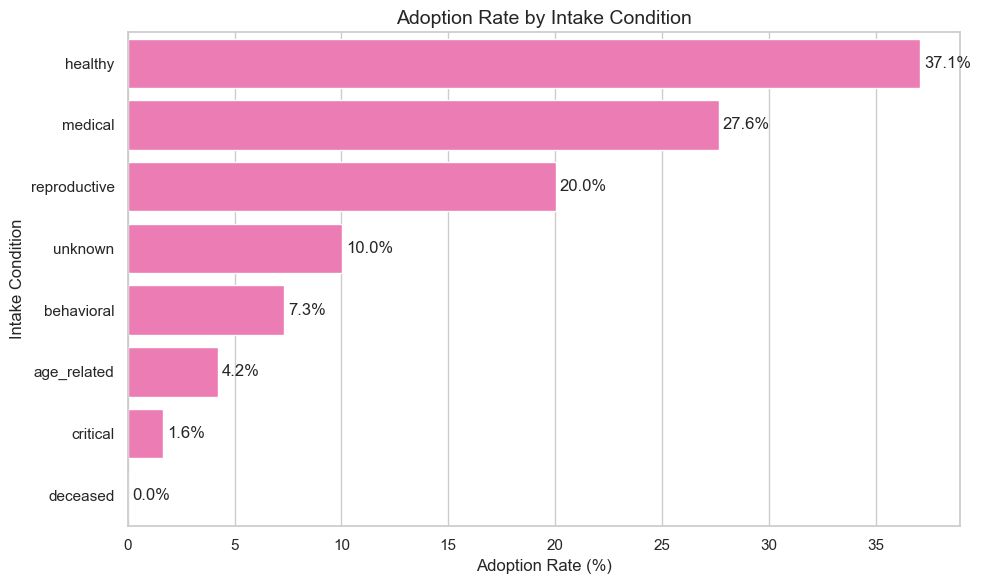

In [37]:
plot_adoption_by_condition(adoption_rate_by_condition(silver_df))

In [38]:
def plot_adoption_by_reason(df):
    """
    Plots a horizontal bar chart showing adoption rate by intake reason.

    Parameters:
        df (pd.DataFrame): Output of adoption_rate_by_reason(), including 'intake_reason' and 'adoption_rate_percent'.
    """
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(
        data=df.sort_values("adoption_rate_percent", ascending=False),
        y="intake_reason",
        x="adoption_rate_percent",
        color="#ff69b4",
    )

    # Add labels
    for container in bars.containers:
        bars.bar_label(container, fmt="%.1f%%", padding=3)

    plt.title("Adoption Rate by Intake Reason", fontsize=14)
    plt.xlabel("Adoption Rate (%)")
    plt.ylabel("Intake Reason")
    plt.tight_layout()
    plt.show()

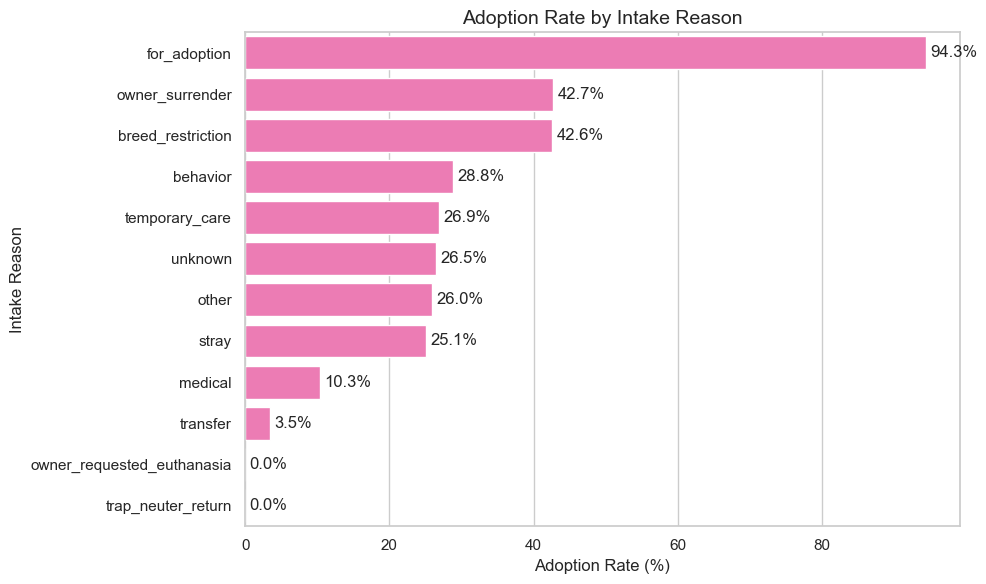

In [39]:
plot_adoption_by_reason(adoption_rate_by_reason(silver_df))

#### Findings:
**Intake Reason:**
1. **For Adoption** leads by a wide margin with an adoption rate of **94.3%**, indicating that animals purposefully entered for adoption are overwhelmingly placed.
2. **Owner Surrender** (42.7%) and **Breed Restriction** (42.6%) follow closely, suggesting that animals relinquished under structured or legal constraints still have strong potential for rehoming.
3. Mid-tier reasons like **Behavior** (28.8%), **Temporary Care** (26.9%), **Unknown** (26.5%), **Other** (26.0%), and **Stray** (25.1%) cluster together, reflecting moderate success.
4. Lower rates are seen for **Medical** (10.3%) and **Transfer** (3.5%).
5. **Owner-Requested Euthanasia** and **Trap-Neuter-Return** register **0% adoption**, consistent with their intent.

**Intake Condition:**
1. **Healthy** animals have the highest adoption rate at **37.1%**, followed by those with **Medical** (27.7%) and **Reproductive** (20.0%) conditions.
2. Lower adoption is observed among animals labeled **Unknown** (10.0%), **Behavioral** (7.3%), or **Age-Related** (4.2%).
3. **Critical** and **Deceased** animals have near-zero or zero adoption rates, reflecting severity or ineligibility.

#### Potential Narrative (linking intake reason & condition):

While the charts display **reason** and **condition** separately, their combined impact on adoption likelihood is logical:

- Animals **entered "for adoption"** likely come with **healthy** or **reproductive** conditions, supporting their near-perfect placement rate.
- **Owner Surrenders** and **Breed Restrictions** may involve mixed conditions (including reproductive or behavioral), yet still show strong rehoming potential.
- **Strays** and animals from **unknown** or **other** reasons often come in with less documented conditions—likely linked to the **unknown**, **age-related**, or **medical** categories seen in the second chart.
- **Medical**, **Transfer**, and **Euthanasia** reasons strongly align with the **critical** or **medical** conditions—explaining their low adoption rates.

This suggests that while **reason and condition are logged separately**, they often **co-occur in meaningful patterns** that influence outcomes.

---

## 6. Time Series Trends

### 6.1: Analysis Question
**Are there consistent seasonal or yearly patterns in intake and adoption rates, and do these trends vary by region?**

Understanding how shelter activity fluctuates over time can help improve resource allocation, staff planning, and targeted outreach. Identifying cyclical trends — such as spikes in stray intakes during the summer or adoption drives during holidays — enables proactive strategy. Additionally, comparing patterns across regions allows us to assess whether certain locations experience unique seasonal pressures.


### Method:

To address this question, we will:

1. **Extract monthly intake and adoption events** from the intake and outcome dates.
2. **Group by calendar month and year** to capture seasonality and longer-term changes.
3. **Disaggregate by region** to compare city-level trends.

### Output:
The resulting table will display:
- A time-indexed dataset of monthly **intake** and **adoption** counts.
  
These outputs will help identify:
- Seasonal intake surges (e.g., kitten/puppy season)
- Gaps between intake and adoption (potential backlog)

### Note: This analysis will take 2023, 2024, 2025(latest) for all three regions to maintain consistency in analysis 

In [40]:
def monthly_intake_adoption_summary_filtered(
    df, intake_col="intake_date", outcome_col="outcome_date"
):
    """
    Creates a monthly summary of intake and adoption events for years 2023, 2024, and 2025.

    Parameters:
        df (pd.DataFrame): Dataset with intake and outcome date columns.
        intake_col (str): Column name for intake datetime.
        outcome_col (str): Column name for adoption datetime.

    Returns:
        pd.DataFrame: Long-format dataframe with monthly counts by region and outcome type.
    """
    # Ensure datetime format
    df[intake_col] = pd.to_datetime(df[intake_col], errors="coerce")
    df[outcome_col] = pd.to_datetime(df[outcome_col], errors="coerce")

    # Intake events
    intake_df = (
        df.dropna(subset=[intake_col])
        .assign(month=lambda d: d[intake_col].dt.to_period("M").dt.to_timestamp())
        .groupby(["region", "month"])
        .size()
        .reset_index(name="count")
        .assign(outcome_type="intake")
    )

    # Adoption events
    adoption_df = (
        df[df["outcome_type"] == "adoption"]
        .dropna(subset=[outcome_col])
        .assign(month=lambda d: d[outcome_col].dt.to_period("M").dt.to_timestamp())
        .groupby(["region", "month"])
        .size()
        .reset_index(name="count")
        .assign(outcome_type="adoption")
    )

    # Combine and sort
    monthly_df = pd.concat([intake_df, adoption_df], ignore_index=True)

    monthly_df = monthly_df[monthly_df["month"].dt.year.isin([2023, 2024, 2025])]
    return monthly_df

In [41]:
check = monthly_intake_adoption_summary_filtered(silver_df)
check["month"].dt.year.unique()

array([2023, 2024, 2025], dtype=int32)

Visualization Question 6.1 : **Are there consistent seasonal or yearly patterns in intake and adoption rates, and do these trends vary by region?** 

In [42]:
def plot_monthly_intake_adoption_by_region(df):
    """
    Plots monthly intake and adoption trends for the years 2023-2025, separated by region.

    Parameters:
        df (pd.DataFrame): Long-format dataframe containing 'region', 'month', 'count', and 'outcome_type' columns.
    """
    # Set plot aesthetics
    sns.set(style="whitegrid")
    palette = {"intake": "#ff69b4", "adoption": "#ffc0cb"}

    # Create FacetGrid for each region
    g = sns.FacetGrid(
        df,
        col="region",
        hue="outcome_type",
        palette=palette,
        col_wrap=3,
        height=4,
        aspect=2,  # wider charts
        sharey=False,
    )

    # Line plot for each facet
    g.map(sns.lineplot, "month", "count")

    # Rotate x-axis labels and set titles
    for ax in g.axes.flatten():
        ax.tick_params(axis="x", rotation=45)
        ax.set_xlabel("Month")
        ax.set_ylabel("Count")

    # Add legend and title
    g.add_legend(title="Outcome Type")
    g._legend.set_bbox_to_anchor((1.05, 0.5))
    g.fig.subplots_adjust(top=0.85, right=0.85)
    g.fig.suptitle(
        "Monthly Intake & Adoption Trends by Region (2023–2025)", fontsize=20
    )

    plt.tight_layout()
    plt.show()

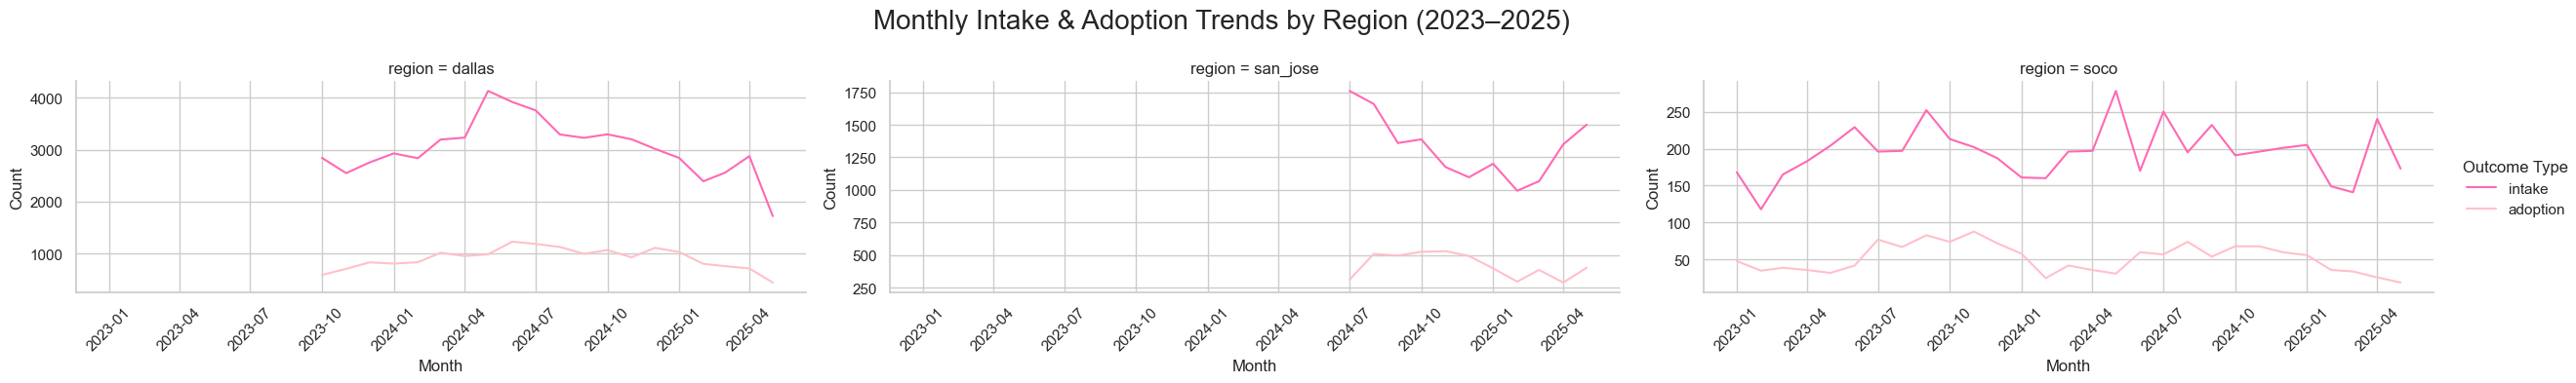

In [43]:
plot_monthly_intake_adoption_by_region(
    monthly_intake_adoption_summary_filtered(silver_df)
)

#### Findings:

**Dallas**
- Intake volume remains high, consistently above 2,500 animals per month, peaking over 4,000 in mid-2023.
- Adoption rates are significantly lower (600–1,200/month), with only minor convergence in early 2024.
- The persistent intake–adoption gap may indicate potential shelter strain or high intake pressure.

**San José**
- Intake starts high and gradually decreases, while adoption remains within a steady relevant range. 
- Adoption volume remains flat across the observed period (~300–500/month), unaffected by intake changes.
- The growing disparity suggests a buildup of animals in the system or limited adoption capacity.

**SoCo**
- Intake volume is low and steady (below 250/month), with minor fluctuation.
- Adoption counts remain modest (~50–100/month) but relatively stable.
- The proportional balance between intake and adoption is more consistent than in other regions.


#### Potential Narrative:

Dallas exhibits the highest operational volume and intake pressure, potentially reflecting its role as a major intake hub or urban shelter. However, the substantial gap between intake and adoptions points to a need for enhanced placement strategies or support.

San José shows reactive trends — a fall and rise in intake — but adoption performance remains stagnant. This may suggest that systemic adoption processes are capacity-bound or under-resourced relative to intake variation.

SoCo appears to maintain a more stable and proportionally balanced system, where adoption tracks intake more closely. While the absolute numbers are lower, this region might offer a model of operational balance or intake regulation that larger shelters could learn from.


---

## 7.Geographic and Shelter-Level Differences  
### 7.1: Analysis Question:
**How do outcomes vary across different cities and shelter regions?**

Understanding geographic differences in shelter performance can reveal important operational patterns, policy gaps, or resource disparities. For instance, regions with longer average shelter stays or lower adoption rates may benefit from targeted interventions, such as increased marketing, improved intake practices, or partnerships with rescue organizations.

### Method:

We will evaluate the following outcome metrics, broken down by **region**:

- **Adoption Rate**  
  
  Adoption Rate = [Number of Animals Adopted] / [Total Animals Intaken (per region)]
  
- **Length of Stay (LoS)**  
  
  Length of Stay = [Outcome Date] - [Intake Date]
   
  This metric captures the average and median number of days an animal remains in shelter care.

- **Outcome Type Distribution**  
  Relative proportions of all outcome types (e.g., adoption, transfer, return to owner, euthanasia).


### Output:

The output will include:

- A **summary table** of average and median Length of Stay for animals with adoption outcomes by region (cats and dogs).
- A **summary table** of the outcome distribution by region with their associated percentages

These insights will help identify cities or shelter networks that excel—or struggle—in achieving positive outcomes, and may inform region-specific improvements.


In [44]:
def adoption_duration_stats_per_species(df):
    """
    Computes average and median number of days adopted animals spent in shelters,
    separated by region and species (e.g., cat, dog).

    Parameters:
        df (pd.DataFrame): Input dataframe with 'intake_date', 'outcome_date',
                           'outcome_type', 'region', and 'animal_type' columns.

    Returns:
        pd.DataFrame: Summary of average and median adoption durations.
    """
    # Ensure datetime format
    df["intake_date"] = pd.to_datetime(df["intake_date"], errors="coerce")
    df["outcome_date"] = pd.to_datetime(df["outcome_date"], errors="coerce")

    # Calculate days to outcome
    df["days_to_outcome"] = (df["outcome_date"] - df["intake_date"]).dt.days

    # Filter adopted animals
    adopted_df = df[df["outcome_type"] == "adoption"].copy()

    # Group by region and animal type to compute mean and median
    duration_stats = (
        adopted_df.groupby(["region", "animal_type"])["days_to_outcome"]
        .agg(mean_days="mean", median_days="median", count="size")
        .reset_index()
    )

    return duration_stats

In [45]:
adoption_duration_stats_per_species(silver_df)

,region,animal_type,mean_days,median_days,count
0,dallas,cat,3.422560,1.0,5067
1,dallas,dog,7.250038,4.0,13101
2,san_jose,cat,15.990627,8.0,3094
3,san_jose,dog,19.709468,8.0,1542
4,soco,cat,33.264434,26.0,4330
5,soco,dog,44.794590,27.0,3919


In [46]:
def outcome_type_summary(df):
    """
    Summarizes the distribution of outcome types by region, including:
    - Total counts
    - Proportion of each outcome type within region
    - Mean and median days spent before outcome

    Parameters:
        df (pd.DataFrame): Input dataset with columns 'region', 'outcome_type', 'intake_date', and 'outcome_date'.

    Returns:
        pd.DataFrame: Summary table with outcome stats per region.
    """
    # Ensure datetime format
    df["intake_date"] = pd.to_datetime(df["intake_date"], errors="coerce")
    df["outcome_date"] = pd.to_datetime(df["outcome_date"], errors="coerce")

    # Compute days in shelter if not already present
    df["days_in_shelter"] = (df["outcome_date"] - df["intake_date"]).dt.days

    # Drop rows with missing outcome_type or days
    df = df.dropna(subset=["outcome_type", "days_in_shelter"])

    # Total outcomes per region
    total_by_region = df.groupby("region").size().rename("total_region")

    # Group by region and outcome type
    outcome_stats = (
        df.groupby(["region", "outcome_type"])
        .agg(
            count=("outcome_type", "size"),
            mean_days=("days_in_shelter", "mean"),
            median_days=("days_in_shelter", "median"),
        )
        .reset_index()
    )

    # Merge with region totals to compute proportions
    outcome_stats = outcome_stats.merge(total_by_region, on="region")
    outcome_stats["percent"] = (
        outcome_stats["count"] / outcome_stats["total_region"]
    ) * 100

    # Round for readability
    outcome_stats["mean_days"] = outcome_stats["mean_days"].round(1)
    outcome_stats["median_days"] = outcome_stats["median_days"].round(1)
    outcome_stats["percent"] = outcome_stats["percent"].round(2)

    return outcome_stats[
        ["region", "outcome_type", "count", "percent", "mean_days", "median_days"]
    ]

In [47]:
outcome_type_summary(silver_df)

,region,outcome_type,count,percent,mean_days,median_days
0,dallas,adoption,18148,30.52,6.2,3.0
1,dallas,deceased,867,1.46,2.9,0.0
2,dallas,disposal,357,0.60,5.5,0.0
3,dallas,euthanasia,5204,8.75,7.1,3.0
4,dallas,foster,10963,18.44,8.4,4.0
5,dallas,found,1424,2.40,35.1,32.0
6,dallas,lost,3470,5.84,35.4,33.0
7,dallas,other,1062,1.79,2.7,0.0
8,dallas,return_to_owner,5478,9.21,3.8,2.0
9,dallas,spay_neuter,135,0.23,9.8,7.0


Visualization Question 7.1 : **How do outcomes vary across different cities and shelter regions?**

In [48]:
def plot_shelter_duration_heatmap(df):
    """
    Plots a heatmap of the mean number of days animals spent in the shelter by region and outcome type.

    Parameters:
        df (pd.DataFrame): DataFrame with columns 'region', 'outcome_type', and 'median_days'.
    """
    # Create pivot table and fill missing values with 0.0
    pivot_df = df.pivot_table(
        index="region", columns="outcome_type", values="median_days", fill_value=0.0
    )

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(
        pivot_df,
        annot=True,
        fmt=".1f",
        cmap=sns.light_palette("pink", as_cmap=True),
        cbar_kws={"label": "Mean Days in Shelter"},
    )

    plt.title("Median Days in Shelter by Region and Outcome Type", fontsize=14)
    plt.xlabel("Outcome Type")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()

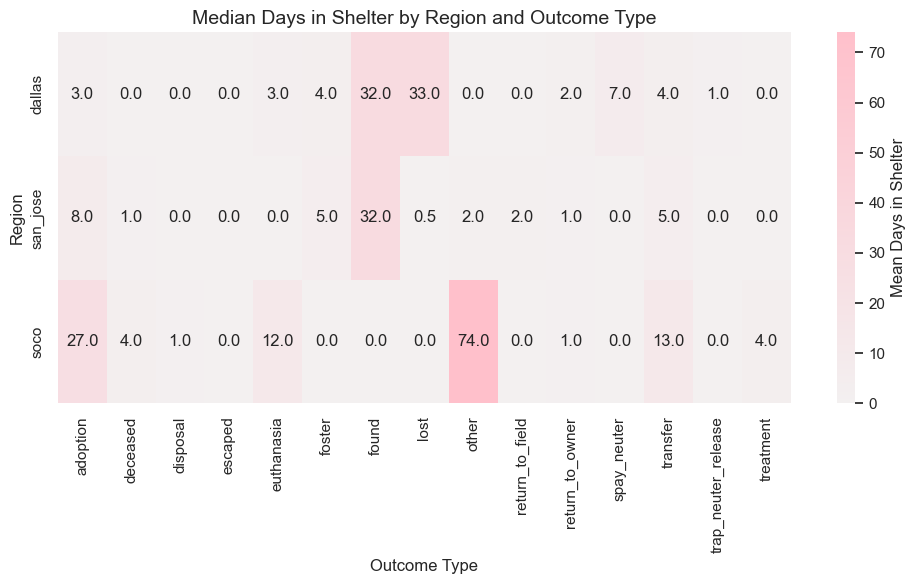

In [49]:
plot_shelter_duration_heatmap(outcome_type_summary(silver_df))

#### Findings:

#### **1. "Other" outcomes in SoCo indicate prolonged stays**
- SoCo has the highest median duration for the `"other"` outcome type (**74 days**), suggesting this category may include long-term or unresolved cases.
- Other regions show far lower values or none for this outcome.

#### **2. “Lost” and “Found” animals remain longest in Dallas and San José**
- In Dallas, `"lost"` and `"found"` outcomes reach **33 and 32 days**, respectively.
- San José shows **32 days** for `"foster"` and `"lost"`, hinting at extended stray holding or fostering arrangements.
- These patterns reflect **delays in reunification or rehoming** for unidentified animals.

#### **3. Adoption times vary significantly by region**
- Median time to adoption:
  - **SoCo**: 27 days  
  - **San José**: 8 days  
  - **Dallas**: 3 days  
- Suggests that SoCo may experience **slower placement pipelines** or adopt a **delayed adoption model**, while Dallas is highly efficient.

#### **4. Euthanasia-related outcomes happen quickly**
- `"euthanasia"`, `"deceased"`, and `"disposal"` generally occur within **1–4 days**, consistent with rapid decision-making for animals in critical condition.

#### **5. Medical and procedural outcomes are fast and consistent**
- Outcomes like `"spay_neuter"`, `"treatment"`, and `"return_to_owner"` typically occur in **under 10 days**, reflecting **efficient operational flow**.


#### Potential Narrative:

This heatmap suggests that while some regions (e.g., **Dallas**) process common outcomes like adoption and return efficiently, others (notably **SoCo**) may face **systemic delays** or manage animals for longer durations—particularly in ambiguous categories like `"other"`. This coupled with intake frequency and adoption frequency implies that certain geographies (**SoCo**) have the previlage and resources to keep animals for extended times in the shelter, unlike **Dallas** & **San Jose** which experience higher volumes of traffic.  

---

## 8. Feature Interactions 

### 8.1: Analysis Objective:
**Which categorical intake attributes are most associated with adoption outcomes?**
Since many of our dataset columns are categorical (e.g., breed, sex, intake type), we can't use standard correlation metrics like Pearson’s r. Instead, we need specialized techniques to measure association (not linear correlation). Experimenting and understanding which features are have the strongest associations and exploring their associated predictive capabilities. 

### Methodology

#### 1. **Filter for Adoption Outcomes**
We restrict the dataset to records where `outcome_type == "adoption"`. This helps isolate the factors associated with successful adoption cases and removes noise from other outcomes (e.g., transfer, euthanasia). 

#### 2. **Select Categorical Features**
The analysis focuses on variables such as:
- `animal_type`, `breed`, `sex`, `primary_color`
- `intake_type`, `intake_condition`, `intake_reason`
- `region`, `age_stage`

These are either intrinsic animal attributes or administrative factors. We excluded non-informative columns like IDs and date fields.

#### 3. **Computing Association & Predictive Strength**
A.**Use Cramér’s V for Association**
Cramér’s V is a symmetric measure of association for categorical variables:
- Derived from the Chi-squared statistic
- Ranges from 0 (no association) to 1 (perfect association)
- Useful for exploratory, pairwise comparisons

**Reasoning:** 
Cramér’s V is an ideal metric for measuring **association strength** between **two categorical variables**, particularly when:
- **Both variables are nominal** (i.e., no natural order, like `breed`, `sex`, `intake_type`)
- You want a **symmetric measure** (i.e., the association between A and B is the same as B and A)
- You are not trying to **predict** one variable from the other, but simply measure how **related** they are
  
This will significantly help us eleminate weak associations within our feature selection to guide our next analysis (Testing direction for prediction)

B. **Use Theil’s U for Predictive Strength**
Theil’s U (Uncertainty Coefficient) is an **asymmetric measure** of association between categorical variables:
- It quantifies how much **knowing one variable reduces the uncertainty** in predicting another
- Ranges from 0 (no predictive value) to 1 (perfect predictability)
- Most useful for evaluating directional relationships, such as from features to outcomes

**Reasoning:**  
Theil’s U is particularly useful when your goal is to **understand how informative one variable is about another**, especially in preparation for **predictive modeling**. It is well-suited when:
- You are assessing the **predictive power** of an intake attribute (e.g., `intake_type`, `region`, or `breed`) for a target like `outcome_type`(eg: adoption)
- Your variables are **nominal categorical** (i.e., no inherent order or ranking, represent distinct groups or types, used as labels, like ,`animal_type`, `sex`, `primary_color`, `intake_type`, and `breed`) and traditional correlation metrics are not appropriate
- You need an **asymmetric** metric to capture directional insight (e.g., `U(outcome_type | intake_reason)` may differ from `U(intake_reason | outcome_type)`)

This metric will help us prioritize which categorical features hold the **most informative value** about adoption outcomes, guiding **feature selection** and enabling more focused modeling and interpretation.

### Output:
The output will include two complementary analytical outputs for categorical intake attributes (filtered to animals with `adoption` outcomes):

#### 1. Cramér’s V Association Matrix
- A **symmetric matrix** that measures the **strength of association** between pairs of categorical variables.
- Values range from **0 (no association)** to **1 (perfect association)**.
- Useful for identifying **strong relationships**, redundancy, or feature grouping opportunities.

#### 2. Theil’s U Predictive Matrix
- An **asymmetric matrix** that quantifies how much **knowing one variable reduces the uncertainty** in predicting another.
- Also scaled from **0 (no predictive value)** to **1 (perfect prediction)**.
- Useful for **ranking features** based on their **predictive informativeness** for downstream modeling.



In [50]:
# first, lets filter our silver_df dataframe to accomodate for rows that have "adoption" as their outcome, since our analysis will focuse soley of the factors
# that influence adoption
adoption_df = silver_df[silver_df["outcome_type"] == "adoption"]

In [51]:
# next, lets define our features by selecting the relevant categorical columns
categorical_cols = [
    "animal_type",
    "breed",
    "primary_color",
    "sex",
    "intake_type",
    "intake_condition",
    "intake_reason",
    "region",
    "age_stage",
]

In [52]:
# defining the function to calculate Cramér’s V (Association Strength)
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1)) if min(k - 1, r - 1) > 0 else np.nan

In [53]:
# defining the function to calculate Theil’s U (Predictive Power)
def conditional_entropy(x, y):
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for (x_val, y_val), xy_count in xy_counter.items():
        p_xy = xy_count / total_occurrences
        p_y = y_counter[y_val] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, 2)
    return entropy


def theils_u(x, y):
    s_xy = conditional_entropy(x, y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = [count / total_occurrences for count in x_counter.values()]
    s_x = -sum(p * math.log(p, 2) for p in p_x if p > 0)
    return 1.0 if s_x == 0 else (s_x - s_xy) / s_x

In [54]:
# combing the functions together to produce a unified dataframe
def compute_cramers_v_and_theils_u(df, columns):
    results = []
    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                v = cramers_v(df[col1], df[col2])
                u = theils_u(df[col1], df[col2])
                results.append(
                    {
                        "Variable_X": col1,
                        "Variable_Y": col2,
                        "Cramers_V": round(v, 4),
                        "Theils_U": round(u, 4),
                    }
                )
    return pd.DataFrame(results)

In [55]:
association_df = compute_cramers_v_and_theils_u(
    adoption_df[categorical_cols], categorical_cols
)

In [56]:
association_df

,Variable_X,Variable_Y,Cramers_V,Theils_U
0,animal_type,breed,0.9865,0.9613
1,animal_type,primary_color,0.3815,0.1368
2,animal_type,sex,0.0423,0.0013
3,animal_type,intake_type,0.1000,0.0075
4,animal_type,intake_condition,0.1814,0.0246
...,...,...,...,...
67,age_stage,sex,0.0091,0.0001
68,age_stage,intake_type,0.1555,0.0881
69,age_stage,intake_condition,0.1999,0.0646
70,age_stage,intake_reason,0.3046,0.2780


#### Visualization Question 8.1 : **Which categorical intake attributes are most associated with adoption outcomes?**

In [57]:
# lets examine Association Strength between the selected categorical features
def plot_cramers_v_heatmap(df, categorical_columns):
    v_df = pd.DataFrame(df)
    v_matrix = v_df.pivot(index="Variable_X", columns="Variable_Y", values="Cramers_V")

    plt.figure(figsize=(10, 8))
    sns.heatmap(v_matrix, annot=True, cmap="RdPu", fmt=".2f")
    plt.title("Cramér’s V Association Matrix (Adoption Outcomes)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

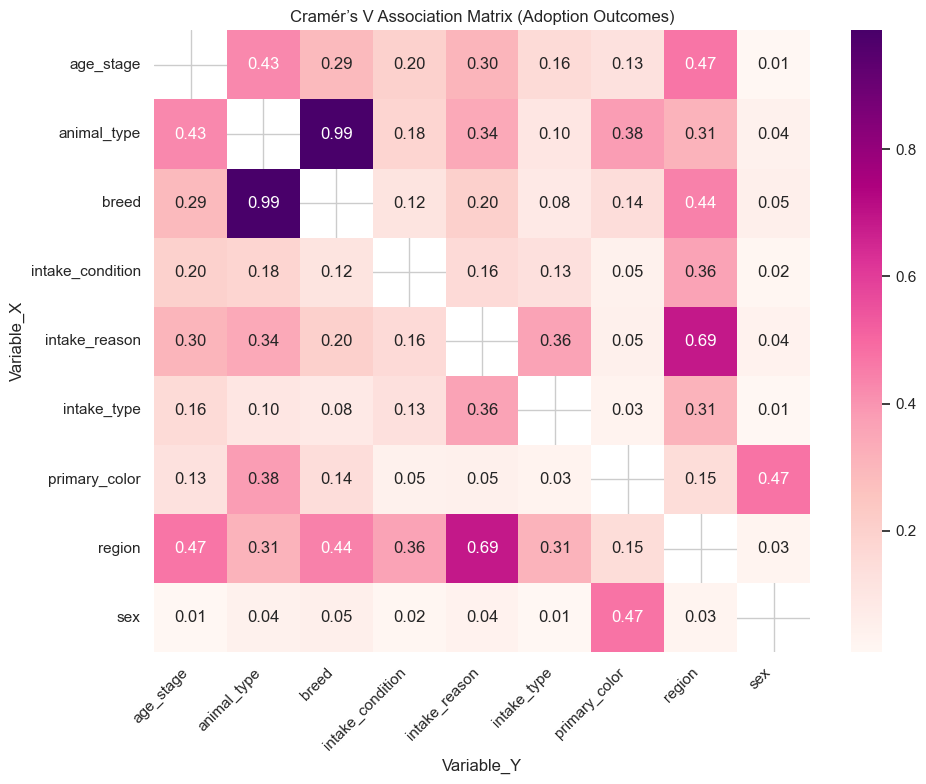

In [58]:
plot_cramers_v_heatmap(association_df, categorical_cols)

In [59]:
# lets examine Predictive Power of each feature
def plot_theils_u_heatmap(df, categorical_columns):
    u_df = pd.DataFrame(df)
    u_matrix = u_df.pivot(index="Variable_X", columns="Variable_Y", values="Theils_U")

    plt.figure(figsize=(10, 8))
    sns.heatmap(u_matrix, annot=True, cmap="PuRd", fmt=".2f")
    plt.title("Theil’s U Predictive Matrix (Adoption Outcomes)")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

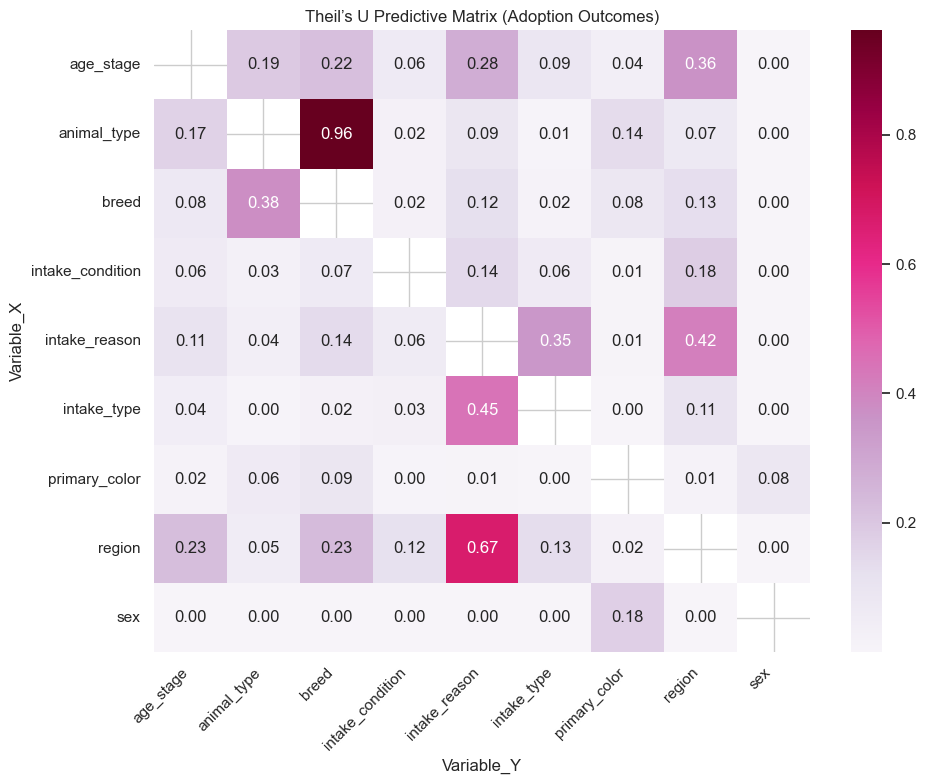

In [60]:
plot_theils_u_heatmap(association_df, categorical_cols)

### Findings from Association and Predictive Matrices
could
We conducted a joint analysis using **Cramér’s V** (for association strength) and **Theil’s U** (for predictive power) to examine relationships between categorical intake features for animals with **adoption outcomes**. This approach helps identify both symmetric associations (structural relationships) and directional dependencies (informative predictors), guiding our understanding of the shelter intake landscape.


#### 1. `animal_type` and `breed` Are Near-Perfectly Linked
- **Cramér’s V ≈ 0.99**, **Theil’s U (breed → animal_type) ≈ 0.96**
- Most breeds are exclusive to either dogs or cats, which makes this pairing **highly redundant**.
- **Interpretation**: If we know the breed, we almost certainly know the animal type—and vice versa.
- **Recommendation**: Avoid using both as inputs to predictive models simultaneously unless interactions are explicitly needed. Consider using breed **as the primary feature**, especially in breed-specific analyses.


#### 2. `breed` Is a Multi-Dimensional Signal
- Strongly **associated with region and intake_reason**, and **predictive of species and intake pathways**.
- **Interpretation**: Certain breeds may be overrepresented in specific regions or linked with specific types of intake (e.g., owner surrender, stray).
- **Recommendation**: Use breed for **model stratification**, e.g., analyzing outcomes by breed group or controlling for breed when modeling regional disparities.


#### 3. `sex` Has Weak Interaction with Other Variables
- Both association and predictive values are **consistently low**.
- **Interpretation**: The sex of the animal doesn't meaningfully co-vary with attributes like breed, intake reason, or region.
- **Recommendation**: While sex may still matter for medical or behavioral sub-studies, it likely does not enhance prediction in intake or outcome models.


#### 4. `primary_color` Is Weakly Informative
- Moderate association with `animal_type` and `sex`, but limited predictive value overall.
- **Interpretation**: While certain colors may be more common among species or sexes (e.g., tortoiseshell in female cats), this does not translate to broad predictive power.
- **Recommendation**: Consider for **visual clustering or public-facing reporting**, but not core predictive modeling.


#### 5. `intake_reason` and `intake_type` Are Operationally Significant
- **Theil’s U (intake_reason → intake_type) ≈ 0.45** — one of the **strongest directional relationships**.
- Also moderately associated with region and species.
- **Interpretation**: Intake reason (e.g., medical, stray, owner surrender) strongly shapes how animals enter the shelter system, and possibly their expected outcomes.
- **Recommendation**: These are **key intake process signals** and should be **included in models predicting adoption likelihood** or time in shelter.


#### 6. `region` Shows Geographic Differentiation
- Moderate association with `breed`, `intake_type`, and `animal_type`; some predictive power as well.
- **Interpretation**: Animal demographics and sheltering dynamics differ across geographic areas—possibly due to policy, population, or climate factors.
- **Recommendation**: Use `region` to support **fairness audits**, **localized decision-making**, or to segment analysis across shelter jurisdictions.


### Feature Summary Table

| Feature          | Strongly Associated With             | Predictive of                      | Use Case                                 |
|------------------|--------------------------------------|-------------------------------------|------------------------------------------|
| `breed`          | `animal_type`, `region`, `intake_reason` | `animal_type`, `intake_reason`      | High-priority predictor and grouping     |
| `sex`            | weak associations overall            | very low predictive power           | Deprioritize in modeling                 |
| `intake_reason`  | `intake_type`, `region`              | `intake_type`, `animal_type`        | High-value operational feature           |
| `primary_color`  | `animal_type`, `sex` (weak-moderate) | minor predictive value              | Limited predictive utility               |
| `region`         | `breed`, `intake_type`, `animal_type`| moderate predictive power           | Useful for geographic segmentation       |


This correlation and predictive analysis provides both a **structural map of relationships** between intake features and a **prioritization guide** for feature selection. It balances:
- **Redundancy detection** (e.g., removing duplicated signals),
- **Informative feature identification** (e.g., prioritizing `breed`, `intake_reason`),
- and **operational insight** (e.g., linking intake context to outcomes or regional dynamics).

These findings will help refine subsequent exploratory and predictive models, guide fairness-aware analysis, and inform shelter strategy across diverse operational contexts.
